# <center>Environmental Sound Classification</center>
---

## Expand the cells width 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Important libraries.

In [1]:
import re
import cv2
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation

Using TensorFlow backend.


## Read the training dataset(Audio files)

In [2]:
audio_files = []
PATH = 'ESC-50/audio'
for file_name in tqdm(os.listdir(PATH)):
    try:
        audio, sampling_rate = librosa.load(os.path.join(PATH,file_name),res_type='kaiser_fast')
        
        # Since class name/number is hidden in file name of audio file, so we have to extract the class name/number by regular expression.
        exp = re.findall('\d{1,2}.wav',file_name)
        audio_files.append([audio,int(float(exp[0][0:2]))])
    except Exception as e:
        pass

100%|██████████| 2000/2000 [01:32<00:00, 21.69it/s]


## Read and Explore the classes.

In [3]:
#Read the Classes and Categories which i alerady saved in 'classes.csv' file

df = pd.read_csv('classes.csv',delimiter = ',') ## header of classes.

categories = df.columns.tolist()

classes =      list(df[categories[0]].values)
classes.extend(list(df[categories[1]].values))
classes.extend(list(df[categories[2]].values))
classes.extend(list(df[categories[3]].values))
classes.extend(list(df[categories[4]].values))
df

,Animals,Natural soundscapes & water sounds,Human/ non-speech sounds,Interior/domestic sounds,Exterior/urban noises
0,Dog,Rain,Crying baby,Door knock,Helicopter
1,Rooster,Sea waves,Sneezing,Mouse click,Chain saw
2,Pig,Crackling fire,Clapping,Keyboard typing,Siren
3,Cow,Crickets,Breathing,"Door,wood creaks",Car horn
4,Frog,Chirping birds,Coughing,Can opening,Engine
5,Cat,Water drops,Footsteps,Washing machine,Train
6,Hen,Wind,Laughing,Vacuum cleaner,Church bells
7,Insects (flying),Pouring water,Brushing teeth,Clock alarm,Airplane
8,Sheep,Toilet flush,Snoring,Clock tick,Crackers
9,Crow,Thunderstorm,Drinking/sipping,Glass breaking,Hand saw


## Explore a random training example
<b>sampling_rate - </b> which keep the flow of number of element per second of audio files

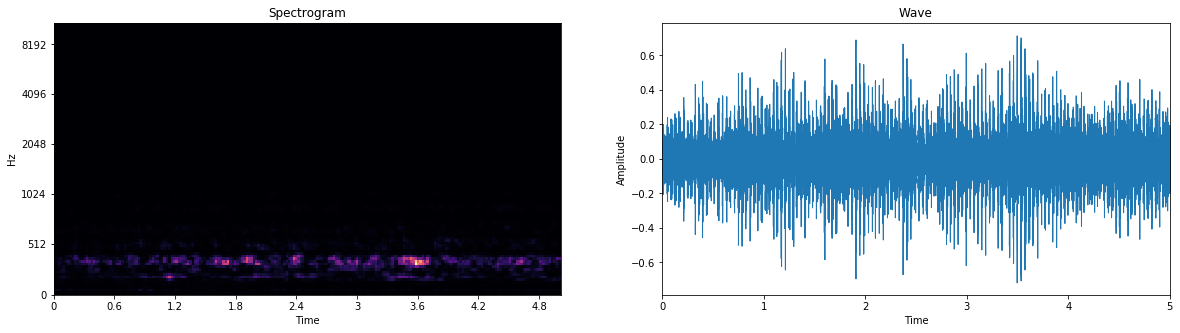

CLASS: Exterior/urban noises
SUBCLASS: Helicopter


In [4]:
number_of_training_example = len(audio_files)

# One random index
random_index = np.random.randint(0,number_of_training_example)

plt.figure(figsize=(20,5))
plt.subplot(121)

audio, _class = audio_files[random_index][0],audio_files[random_index][1]

# Convert audio into spectrogram
spectrogram = librosa.feature.melspectrogram(audio)
plt.title("Spectrogram")
librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')

# Convert into wave form 
sampling_rate = int(len(audio)/5)
plt.subplot(122)
plt.title("Wave")
librosa.display.waveplot(audio, sr=sampling_rate)
plt.ylabel('Amplitude')
plt.show()

print('CLASS:',categories[int(_class/10)])
print('SUBCLASS:',classes[_class])

#Audio
Audio(audio,rate = sampling_rate)

In [5]:
audio_files= np.array(audio_files)
X = list(audio_files[:,0])
Y = audio_files[:,1]
del audio_files

## Augmentation<br>

<li><b> Data augmentation</b> is a technique to artificially create new training data from existing training data.</li>
<li> Since available dataset is not sufficient to train the model so i added the <b>white noise</b> to existing dataset.</li>
<li>Now we have 4000 training example.</li>

In [6]:
# It will take few seconds for augmentation.
size_of_audio_files = len(X[0])
number_of_audio_files = len(Y)

augmented_audio_files = []

for i in range(number_of_audio_files): 
    
    # Adding white noise
    X.append(X[i] + 0.005*np.random.randn(size_of_audio_files))
    
Y = np.r_[Y,Y]

## Split  dataset into training and testing

In [7]:
train_x,test_x,train_y,test_y = train_test_split(X, Y, test_size = 0.1, random_state=5, shuffle = True)

## Convert the input data into spectrogram to train the model

In [8]:
# It will take few seconds to covert audio into Spectrogram_files
x = train_x
train_x = []
length = len(train_y)
for i in range(length):
    train_x.append(librosa.feature.melspectrogram(x[i], sampling_rate))
del x    

In [9]:
# get the input diamention
SPEC_H, SPEC_W = train_x[0].shape
train_x = np.reshape(train_x,(length,SPEC_H, SPEC_W,1))
print(train_x.shape)

(3600, 128, 216, 1)


## Create Compile and Train the model

In [12]:
# create the model
model = Sequential()

# add layers
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(SPEC_H, SPEC_W, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation="softmax"))

# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training and Evaluation of the model
model.fit(train_x, train_y, batch_size = 30 ,epochs=30,validation_split=0.1)

Train on 3240 samples, validate on 360 samples
Epoch 1/30
3240/3240 [==============================] - 20s - loss: 3.9747 - acc: 0.0843 - val_loss: 3.3864 - val_acc: 0.1778
Epoch 2/30
3240/3240 [==============================] - 19s - loss: 3.1933 - acc: 0.1920 - val_loss: 2.7765 - val_acc: 0.2778
Epoch 3/30
3240/3240 [==============================] - 19s - loss: 2.6745 - acc: 0.3000 - val_loss: 2.4671 - val_acc: 0.3472
Epoch 4/30
3240/3240 [==============================] - 19s - loss: 2.3169 - acc: 0.3784 - val_loss: 1.9740 - val_acc: 0.4639
Epoch 5/30
3240/3240 [==============================] - 19s - loss: 2.0042 - acc: 0.4608 - val_loss: 1.7291 - val_acc: 0.5500
Epoch 6/30
3240/3240 [==============================] - 20s - loss: 1.7225 - acc: 0.5448 - val_loss: 1.5358 - val_acc: 0.5778
Epoch 7/30
3240/3240 [==============================] - 19s - loss: 1.5907 - acc: 0.5750 - val_loss: 1.6456 - val_acc: 0.6028
Epoch 8/30
3240/3240 [==============================] - 20s - loss: 1.4

## Test some random unseen example

In [16]:
def test_model(test_x,test_y):
    random_index = np.random.randint(0,len(test_x))
    audio = test_x[random_index]

    plt.figure(figsize=(20,5))
    plt.subplot(121)

    # Generating Spectrogram of audio file.
    spectrogram = librosa.feature.melspectrogram(audio,sampling_rate)
    plt.title("Spectrogram")
    librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')

    # Generating wave form of audio file.
    plt.subplot(122)
    plt.title("Wave")
    librosa.display.waveplot(audio, sr=sampling_rate)
    plt.ylabel('Amplitude')
    plt.show()

    spectrogram = np.reshape(spectrogram,(1,SPEC_H, SPEC_W,1))
    prediction = list(model.predict(spectrogram).flatten())
    print("Predicted category:",categories[prediction.index(max(prediction))//10])
    print("Actual category:",categories[test_y[random_index]//10])

    print('\nPredicted class:',classes[prediction.index(max(prediction))])
    print('Actual class:',classes[test_y[random_index]])


    #Audio
    Audio(audio,rate = sampling_rate)

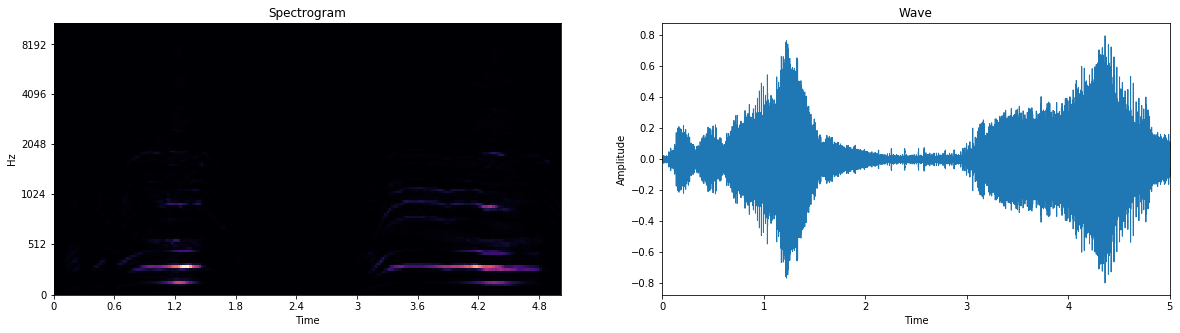

Predicted category: Exterior/urban noises
Actual category: Exterior/urban noises

Predicted class: Chain saw
Actual class: Chain saw


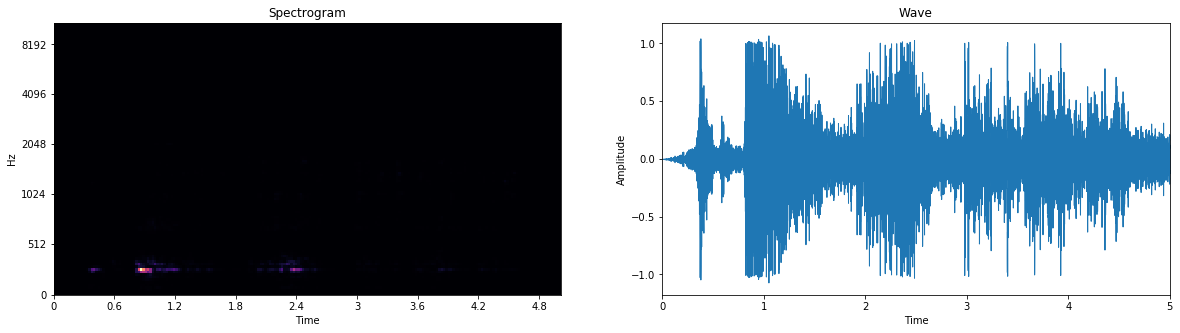

Predicted category: Natural soundscapes & water sounds
Actual category: Natural soundscapes & water sounds

Predicted class: Toilet flush
Actual class: Toilet flush


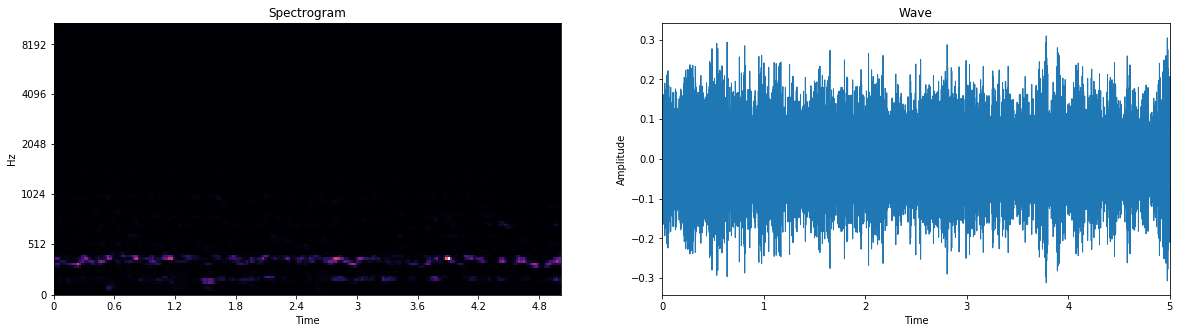

Predicted category: Animals
Actual category: Animals

Predicted class: Insects (flying)
Actual class: Insects (flying)


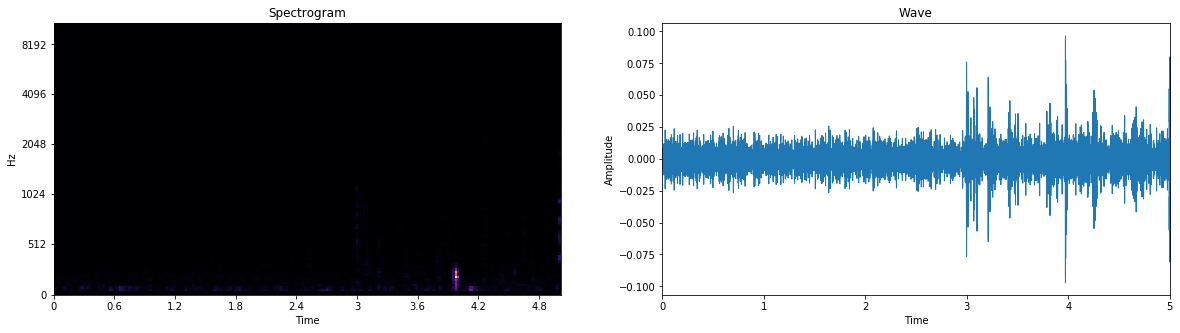

Predicted category: Human/ non-speech sounds
Actual category: Human/ non-speech sounds

Predicted class: Footsteps
Actual class: Footsteps


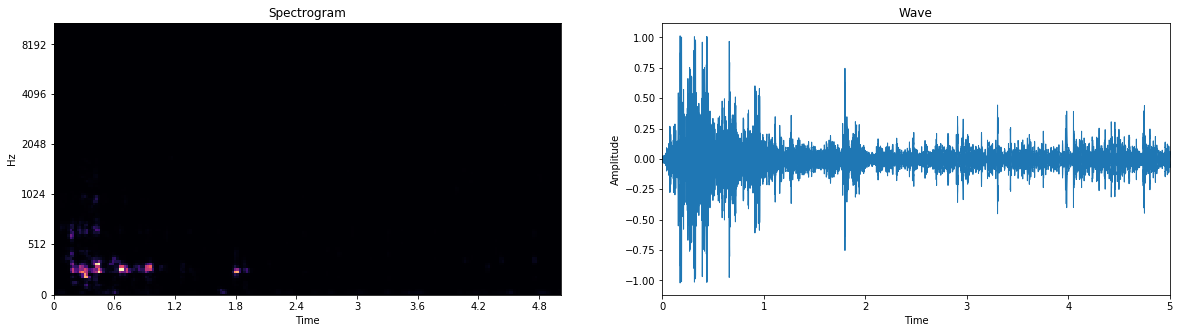

Predicted category: Natural soundscapes & water sounds
Actual category: Natural soundscapes & water sounds

Predicted class: Toilet flush
Actual class: Toilet flush


In [17]:
for i in range(5):
    test_model(test_x,test_y)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 214, 64)      640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 107, 64)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 105, 128)      73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 52, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 50, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 25, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 23, 256)       590080    
__________